In [ ]:
import torch
from omegaconf import DictConfig
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger

import numpy as np

from tsl import logger
from tsl.data import ImputationDataset, SpatioTemporalDataModule
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import AirQuality, MetrLA, PemsBay
from tsl.engines import Imputer
from tsl.experiment import Experiment
from tsl.metrics import numpy as numpy_metrics
from tsl.metrics import torch as torch_metrics
from tsl.nn.models import (BiRNNImputerModel, GRINModel, RNNImputerModel,
                           SPINHierarchicalModel, SPINModel)
from tsl.transforms import MaskInput
from tsl.utils.casting import torch_to_numpy

from my_datasets import AirQualitySmaller, AirQualityAuckland, AirQualityKrig, add_missing_sensors
from Imputation.baselines.KITS import KITS
from unnamedKrig import UnnamedKrigModel

from omegaconf import OmegaConf

from my_datasets import AirQualitySmaller, AirQualityAuckland, AirQualityKrig

import matplotlib.pyplot as plt

from torch_geometric.utils import dense_to_sparse, get_ppr
from my_datasets import AirQualitySmaller, AirQualityAuckland, AirQualityKrig, add_missing_sensors
import networkx as nx

import tqdm

In [3]:
def get_model_class(model_str):
    if model_str == 'rnni':
        model = RNNImputerModel
    elif model_str == 'birnni':
        model = BiRNNImputerModel
    elif model_str == 'grin':
        model = GRINModel
    elif model_str == 'spin':
        model = SPINModel
    elif model_str == 'spin-h':
        model = SPINHierarchicalModel
    elif model_str == 'kits':
        model = KITS
    elif model_str == 'unkrig':
        model = UnnamedKrigModel
    else:
        raise NotImplementedError(f'Model "{model_str}" not available.')
    return model


def get_dataset(dataset_name: str, p_fault=0., p_noise=0., t_range = ['2022-04-01', '2022-12-01'],
                masked_s=None, agg_func = 'mean', test_month=[5], location='Auckland'):
    if dataset_name == 'air':
        return AirQualityKrig(impute_nans=True, small=True, masked_sensors=masked_s, p=p_noise)
    if dataset_name == 'air_smaller':
        return AirQualitySmaller('../../AirData/AQI/Stations', impute_nans=True, masked_sensors=masked_s)
    if dataset_name == 'air_auckland' or dataset_name == 'air_invercargill1' or dataset_name == 'air_invercargill2':
        return AirQualityAuckland('../../AirData/Niwa', t_range=t_range, masked_sensors=masked_s, 
                                  agg_func=agg_func, test_months=test_month,
                                  location=location, p=p_noise)
    if dataset_name.endswith('_point'):
        p_fault, p_noise = 0., 0.25
        dataset_name = dataset_name[:-6]
    if dataset_name.endswith('_block'):
        p_fault, p_noise = 0.0015, 0.05
        dataset_name = dataset_name[:-6]
    if dataset_name == 'metrla':
        return add_missing_sensors(MetrLA(freq='5T'),
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  seed=9101112, 
                                  masked_sensors=masked_s)
    if dataset_name == 'bay':
        return add_missing_sensors(PemsBay(),
                                  p_fault=p_fault,
                                  p_noise=p_noise,
                                  min_seq=12,
                                  max_seq=12 * 4,
                                  seed=56789,
                                  masked_sensors=masked_s)
    raise ValueError(f"Dataset {dataset_name} not available in this setting.")

In [4]:
# mask_s = [0, 4, 5, 6, 10, 13, 14, 15, 16, 18, 19, 21, 22, 23, 24, 26, 29, 31, 32]
mask_s = [26, 126, 200, 21, 121, 18, 189, 50, 35, 182, 181, 180, 186, 59, 150, 8, 34, 185, 46, 66, 203, 149, 87, 100, 14, 86, 104, 112, 89, 151, 148, 172, 88, 202, 9, 51, 84, 204, 130, 41, 197, 77, 194, 43, 45, 44, 92, 153, 152, 146, 105, 120, 99, 158, 179, 131, 201, 167, 106, 82, 76, 11, 110, 178, 55, 173, 81, 62, 169]
mask_s= [1, 2, 3, 4, 5, 6]
mask_s = [7, 8, 10, 11, 12, 16, 19, 25, 26, 27, 29, 31, 33, 36, 41, 42, 44, 45, 47, 48, 51, 55, 58, 64, 71, 74, 77, 80, 83, 97, 98, 101, 103, 106, 107, 108, 114, 117, 122, 123, 126, 127, 136, 146, 148, 150, 158, 160, 161, 164, 181, 186, 187, 189, 192, 196, 199, 202, 204]
mask_s = range(1, 12)
# mask_s = [0, 5, 18, 19, 31]

dataset = get_dataset('air', p_noise=0.25, masked_s=mask_s)
# covariates = {'u': dataset.datetime_encoded('day').values}
adj = dataset.get_connectivity(method='distance', threshold=0.00001, include_self=False, layout='dense', force_symmetric=True)
unmaked_sensors = [i for i in range(adj.shape[0]) if i not in mask_s]
batch_size = 64
horizon = 24

In [5]:
torch_dataset = ImputationDataset(
    target=dataset.dataframe(),
    mask=dataset.training_mask,
    eval_mask=dataset.eval_mask,
    # covariates=covariates,
    transform=MaskInput(),
    connectivity=adj,
    window=horizon,
    stride=1
)

dm = SpatioTemporalDataModule(
    dataset=torch_dataset,

    splitter=dataset.get_splitter(val_len=0.1, test_len=0.2),
    batch_size=batch_size,
    workers=0)

OKRIG

In [6]:
from pykrige.ok import OrdinaryKriging
import numpy as np
import numpy as np
import scipy.sparse
import scipy.sparse.csgraph

def classical_mds_with_inf(D, d=2):
    """
    Classical MDS with support for infinite distances by computing shortest paths.
    D: (n x n) distance matrix with finite and inf values.
    d: target embedding dimension (e.g., 2 for x-y)
    Returns: (n x d) coordinate matrix
    """
    # Step 1: Replace inf by computing shortest paths (graph interpretation)
    D_filled = scipy.sparse.csgraph.floyd_warshall(D, directed=False)

    # Step 2: Classical MDS (same as before)
    n = D_filled.shape[0]
    D_squared = D_filled ** 2
    J = np.eye(n) - np.ones((n, n)) / n
    B = -0.5 * J @ D_squared @ J

    # Step 3: Eigen-decomposition
    eigvals, eigvecs = np.linalg.eigh(B)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Step 4: Keep top d components
    L = np.diag(np.sqrt(np.maximum(eigvals[:d], 0)))
    V = eigvecs[:, :d]
    X = V @ L
    return X



In [7]:
coords = classical_mds_with_inf(dataset.dist)
coords.shape

(36, 2)

In [8]:
dm.setup(stage='fit')

In [9]:
from einops import rearrange

batch_data = next(iter(dm.test_dataloader()))        
dm.test_dataloader()

In [10]:
coords_train = coords[unmaked_sensors]
coords_test = coords[mask_s]

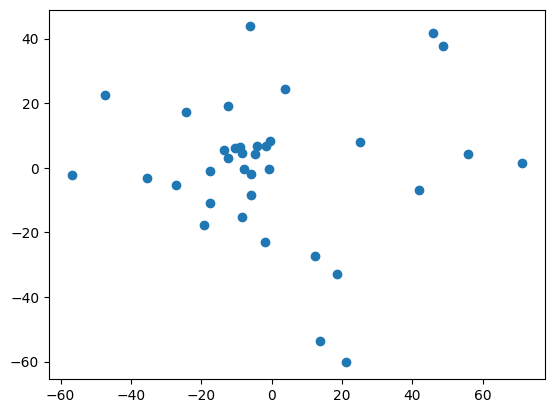

In [11]:
plt.scatter(coords[:, 0], coords[:, 1])

In [14]:
for ind, batch_data in enumerate(iter(dm.train_dataloader())):
    pass
print(ind)

77


In [35]:
y_hats = []
y_trues = []

counter = 44
prog_bar = tqdm.tqdm(range(counter))

for ind, batch_data in enumerate(iter(dm.test_dataloader())):
    b, h, n, d = batch_data.y.shape
    y_s = batch_data.y.view(b*h, -1, 1)

    y_s_train = y_s[:, unmaked_sensors]
    y_s_test = y_s[:, mask_s]

    
    for i in range(b*horizon):
        # print(coords_train.shape, y_s.shape)
        OK = OrdinaryKriging(
            coords_train[:, 0],
            coords_train[:, 1],
            y_s_train[i, :, 0],
            variogram_model="linear",
            verbose=False,
            enable_plotting=False,
        )

        z, s = OK.execute('points',
            coords_test[:, 0],
            coords_test[:, 1])
        
        y_trues.append(y_s_test[i])
        y_hats.append(z)

    prog_bar.update(1)
    if counter <= 0:
        break
    else:
        counter-=1

prog_bar.close()

  0%|          | 0/44 [00:09<?, ?it/s]
45it [10:31, 14.04s/it]


In [36]:
y_hats_np = np.stack(y_hats)
y_trues_np = np.stack(y_trues)[:, :, 0]

In [37]:
y_trues_np = y_trues_np.reshape(-1, horizon, 11)
y_hats_np = y_hats_np.reshape(-1, horizon, 11)
batch = y_hats_np.shape[0]

In [38]:
y_hats_np.data.shape

(2836, 24, 11)

(2836, 24, 11)


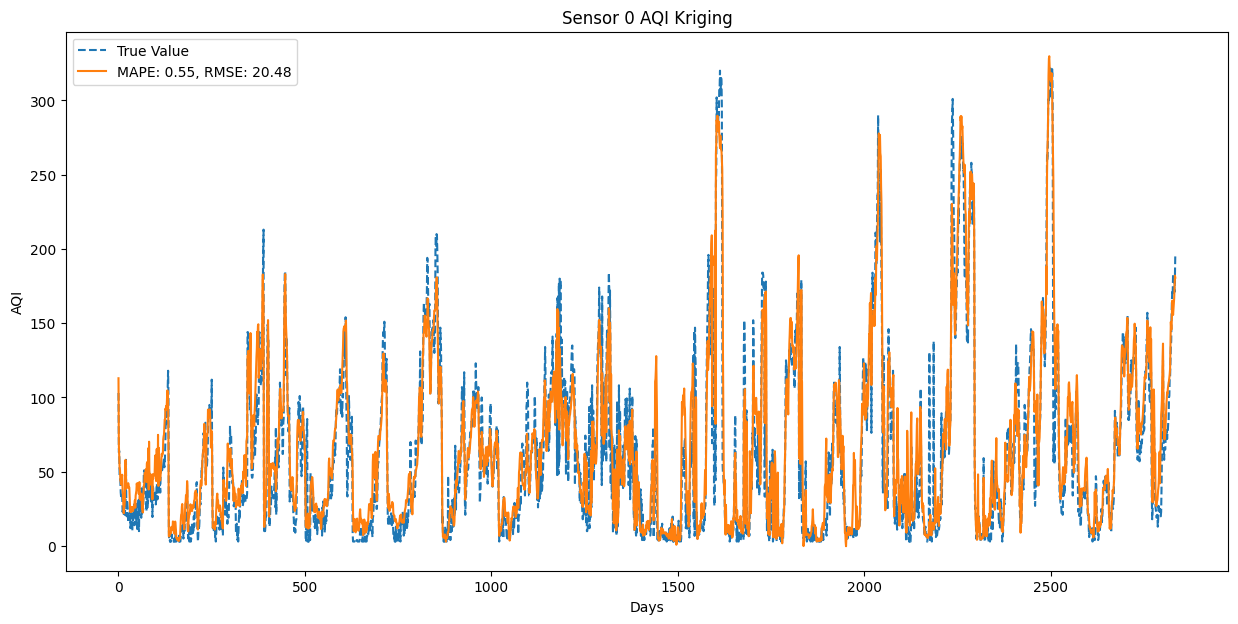

(2836, 24, 11)


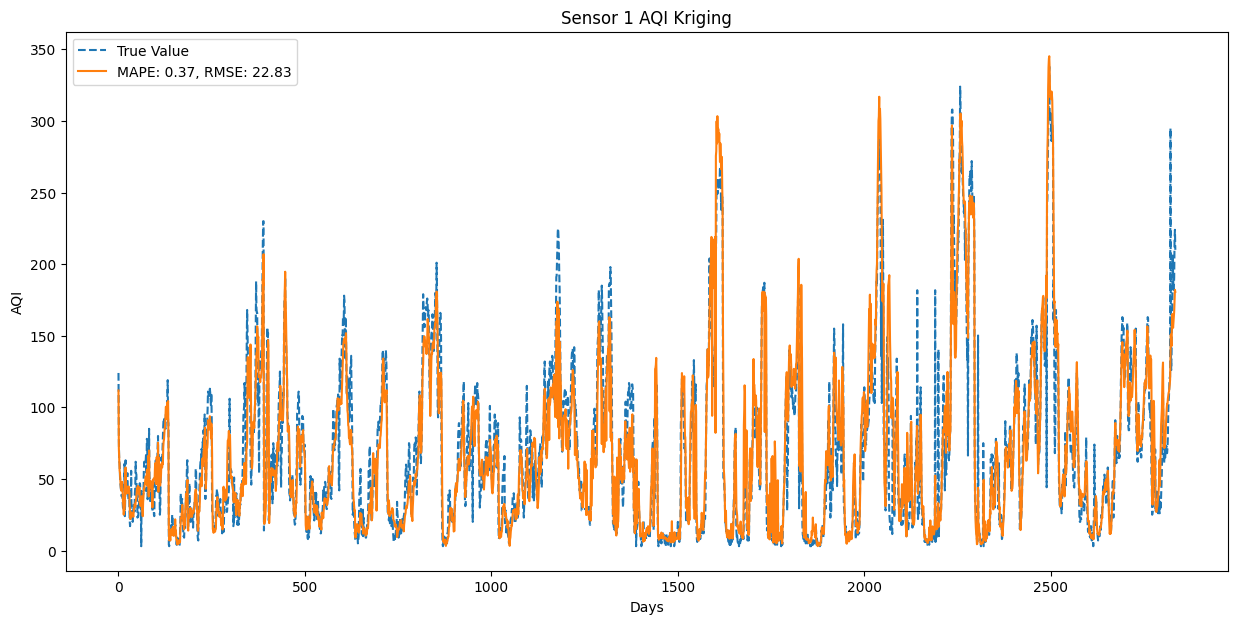

(2836, 24, 11)


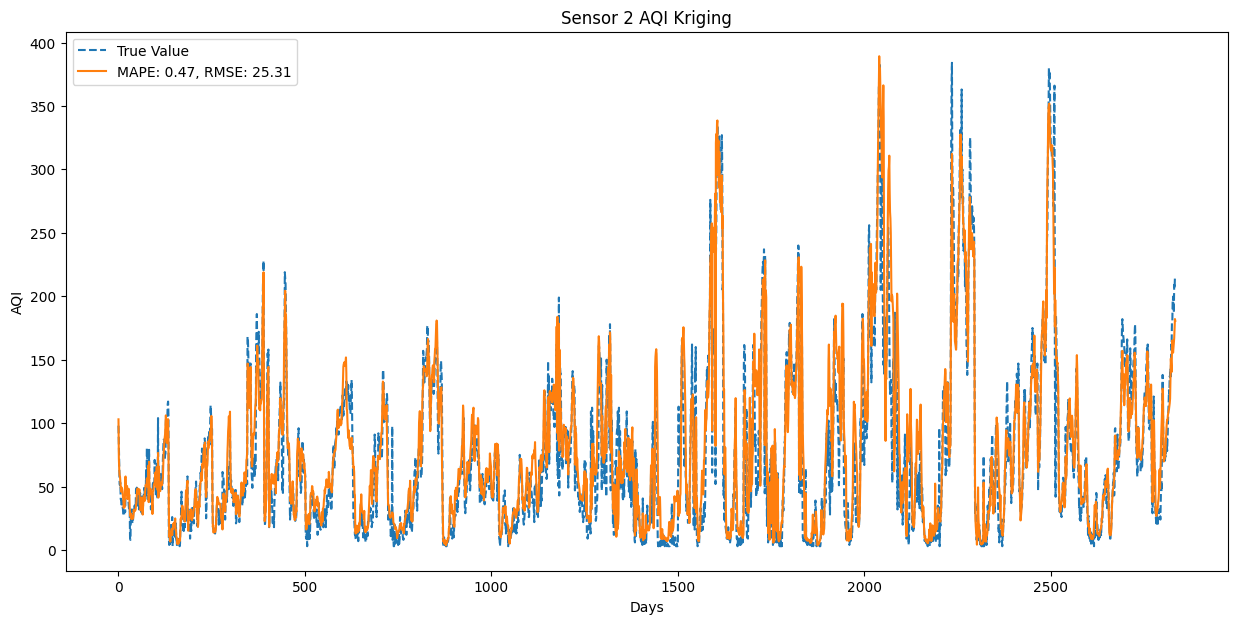

(2836, 24, 11)


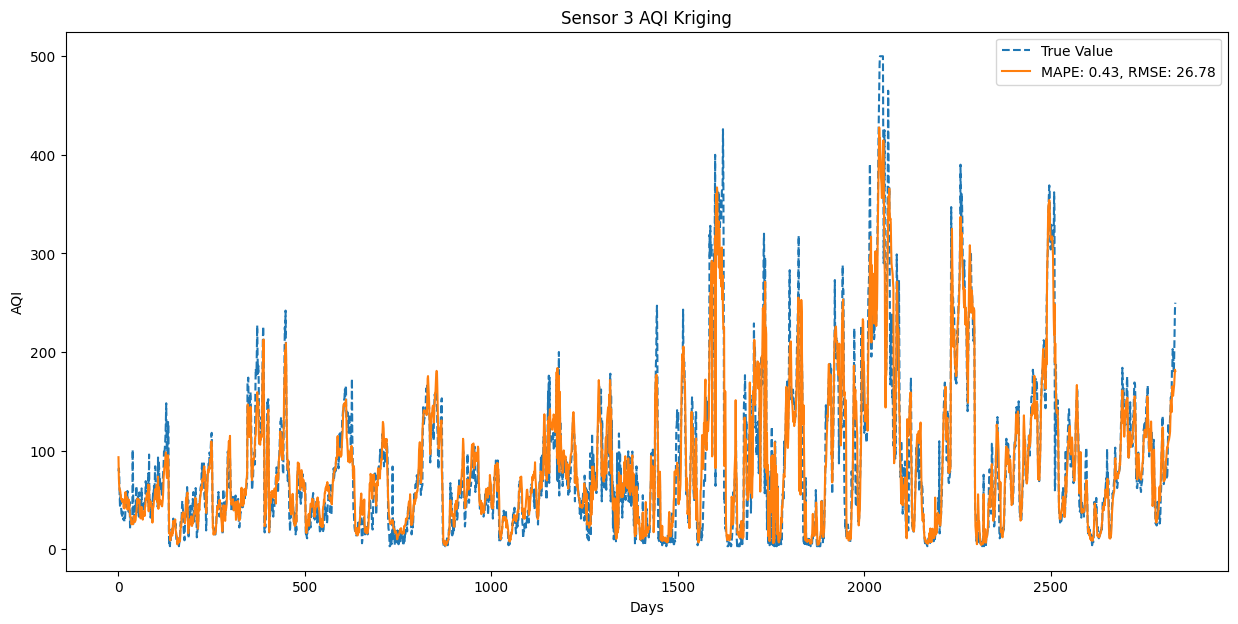

(2836, 24, 11)


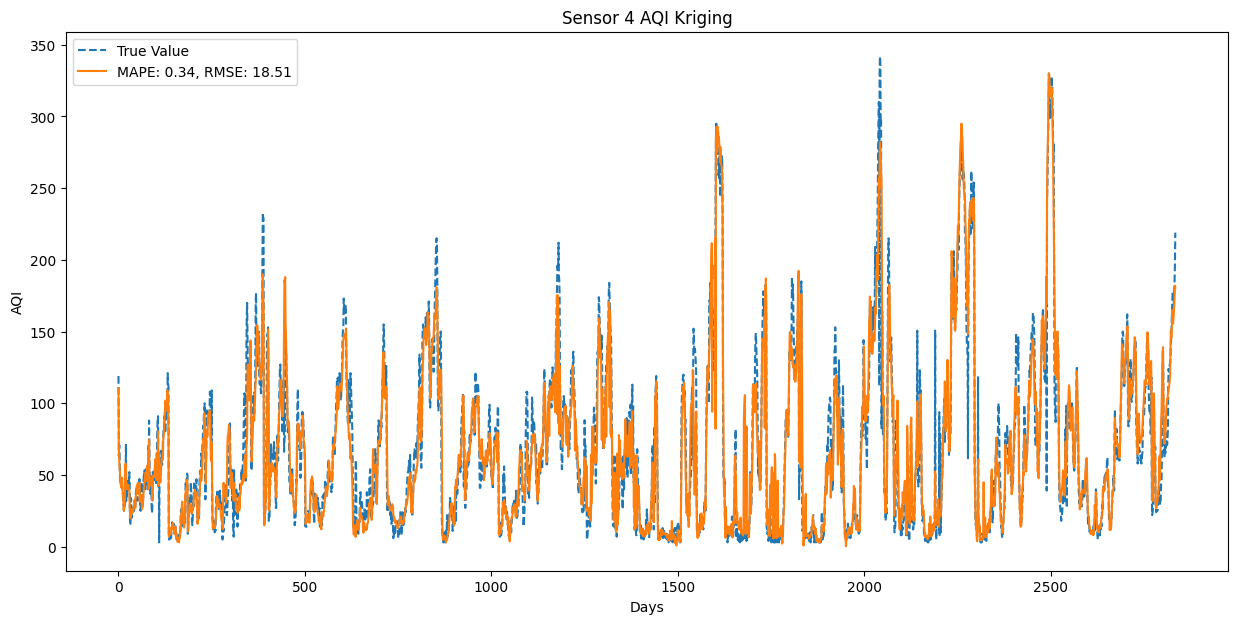

(2836, 24, 11)


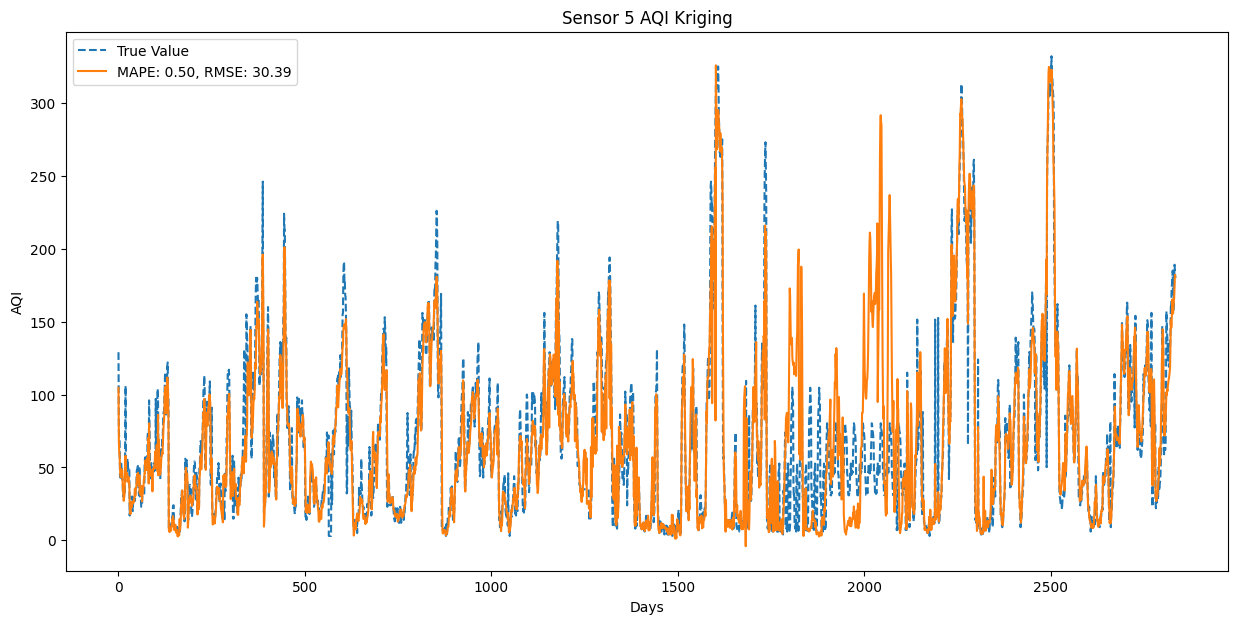

(2836, 24, 11)


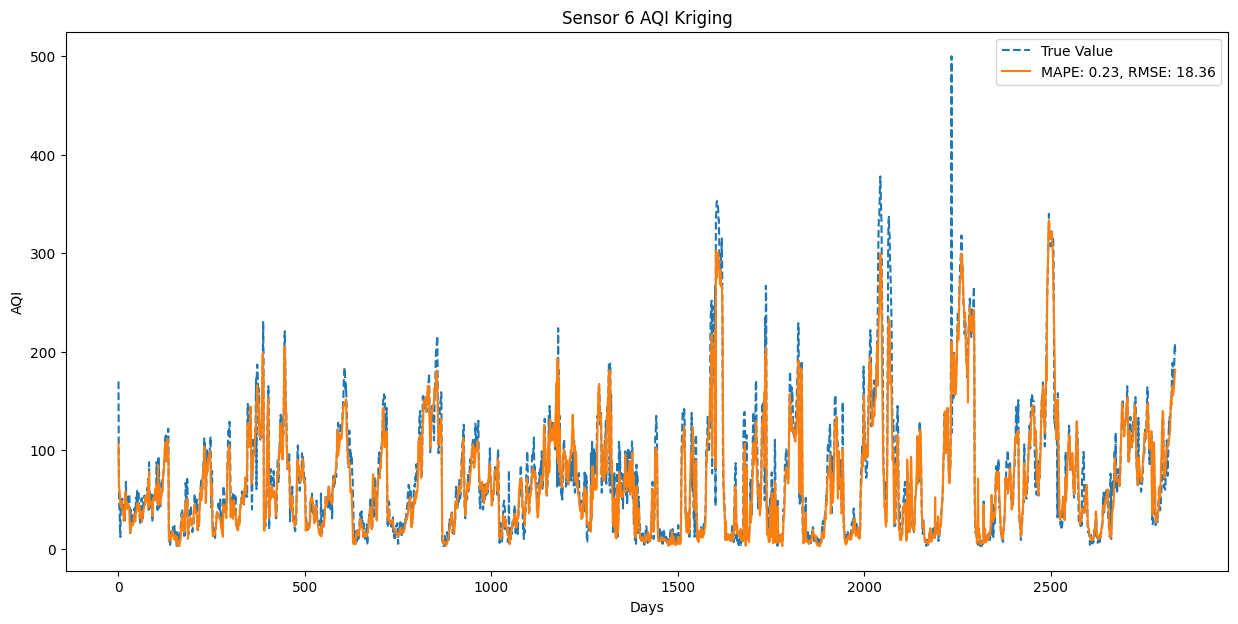

(2836, 24, 11)


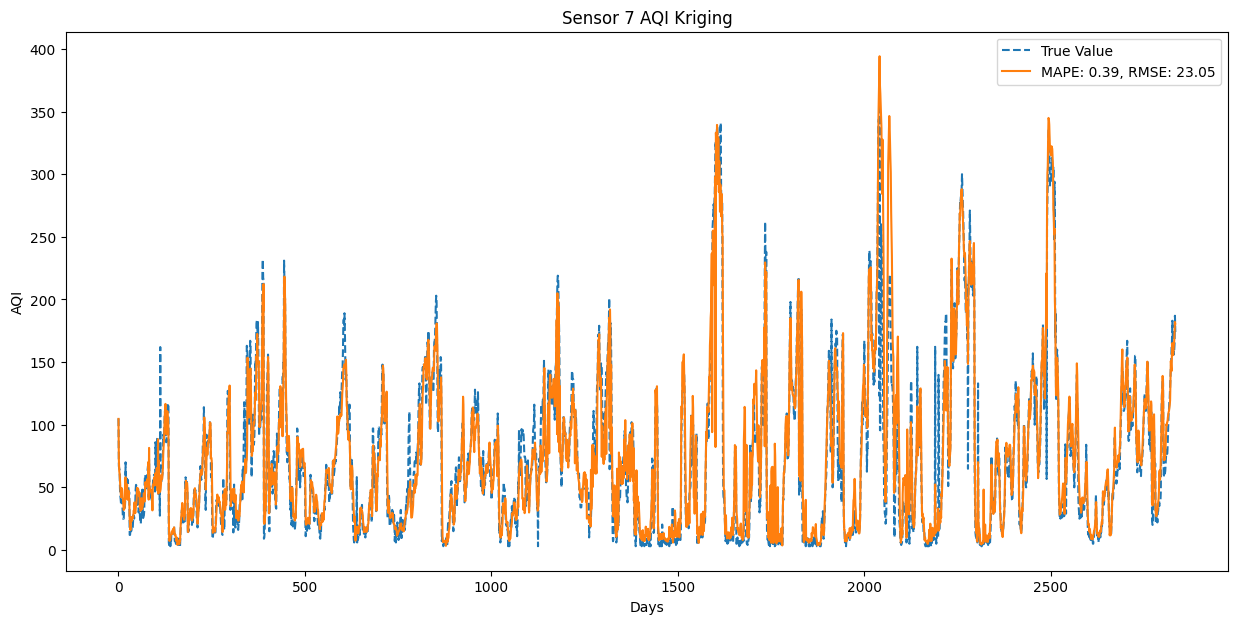

(2836, 24, 11)


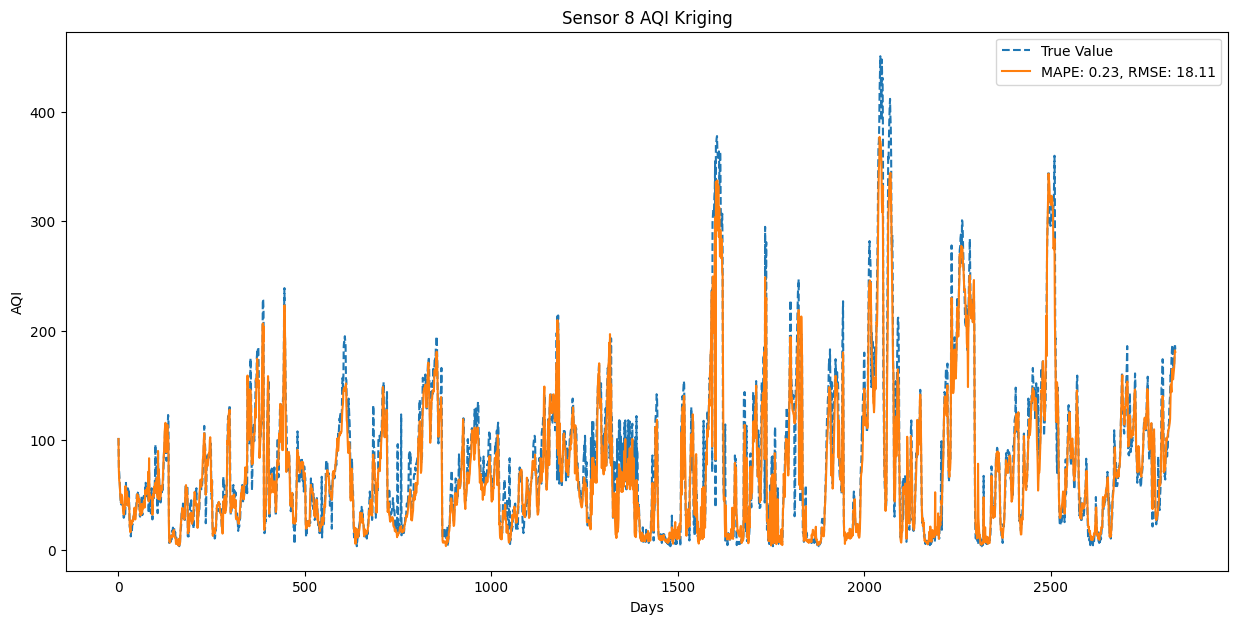

(2836, 24, 11)


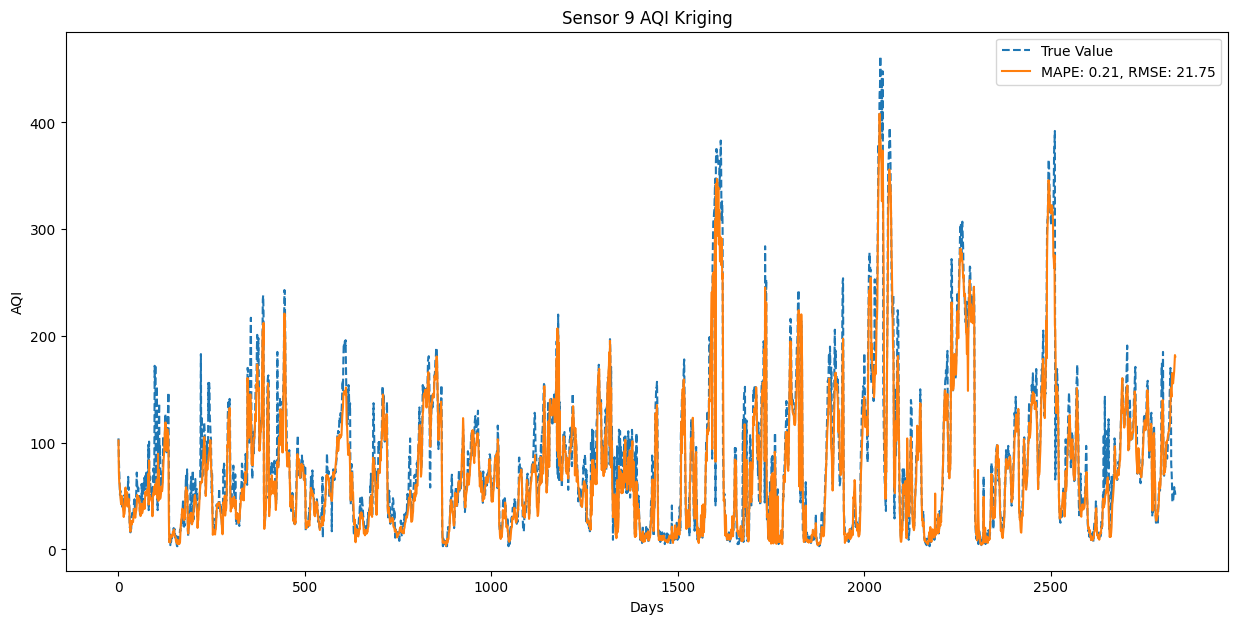

(2836, 24, 11)


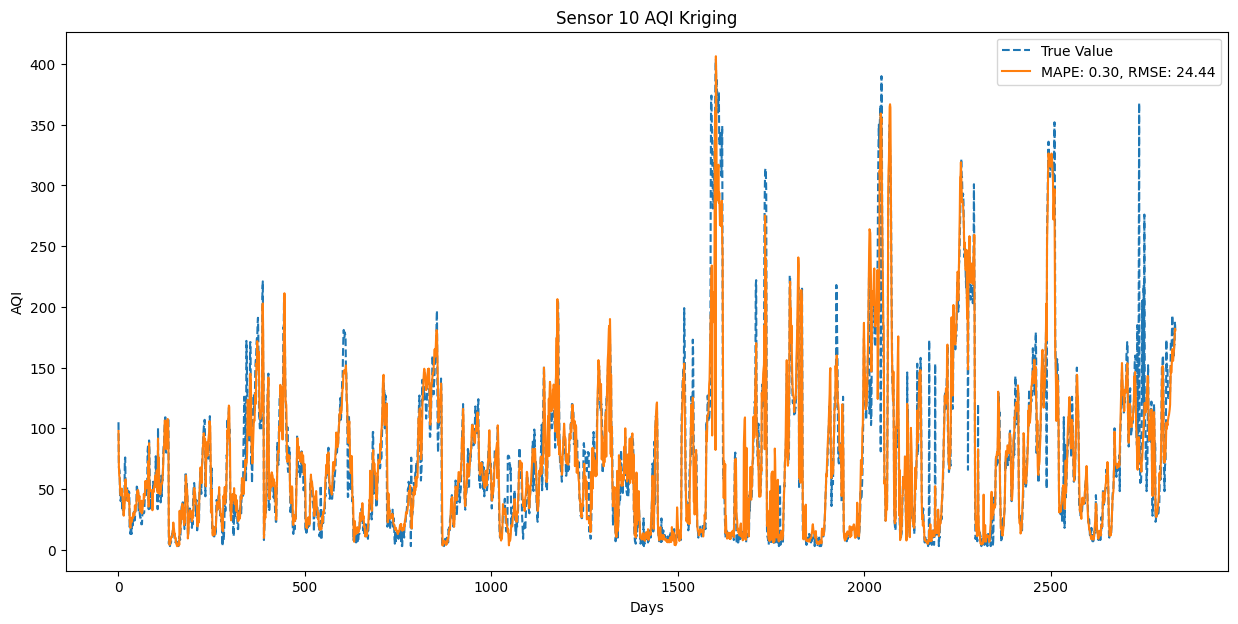

In [39]:
ranges = [0, -1]


y_true = y_trues_np

for sensor in range(len(mask_s)):
    plt.figure(figsize=(15,7))
    plt.plot(y_true[ranges[0]:ranges[1], 0, sensor], '--', label='True Value')
    y_hat = y_hats_np
    print(y_hat.shape)
    test_mape=numpy_metrics.mape(y_hat[ranges[0]:ranges[1], :, sensor], 
                                y_true[ranges[0]:ranges[1], :, sensor])
    test_rmse=numpy_metrics.rmse(y_hat[ranges[0]:ranges[1], :, sensor], 
                                y_true[ranges[0]:ranges[1], :, sensor])

    plt.plot(y_hat[ranges[0]:ranges[1], 0, sensor], label=f'MAPE: {test_mape:.2f}, RMSE: {test_rmse:.2f}')

    # plt.ylim((0, 100))
    plt.xlabel('Days')
    plt.ylabel('AQI')
    plt.legend()
    plt.title(f'Sensor {sensor} AQI Kriging')
    plt.show()

In [40]:
reses = []

for i in range(5):
    y_hat_cur = y_hats_np[batch//5 * i : batch//5 * (i+1)]
    y_tru_cur = y_trues_np[batch//5 * i : batch//5 * (i+1)]
    res = dict(test_mae=numpy_metrics.mae(y_hat_cur, y_tru_cur),
                test_mre=numpy_metrics.mre(y_hat_cur, y_tru_cur),
                test_mape=numpy_metrics.mape(y_hat_cur, y_tru_cur),
                test_mse=numpy_metrics.mse(y_hat_cur, y_tru_cur),
                test_rmse=numpy_metrics.rmse(y_hat_cur, y_tru_cur))
    reses.append(res)
reses

[{'test_mae': np.float64(9.948349529775722),
  'test_mre': np.float64(0.1767946451184398),
  'test_mape': np.float64(0.28246228915772686),
  'test_mse': np.float64(230.68307357379163),
  'test_rmse': np.float64(15.188254461056136)},
 {'test_mae': np.float64(11.099003656279379),
  'test_mre': np.float64(0.17507698895492968),
  'test_mape': np.float64(0.3036619991679734),
  'test_mse': np.float64(250.40569160669085),
  'test_rmse': np.float64(15.82421219545197)},
 {'test_mae': np.float64(15.605350949593767),
  'test_mre': np.float64(0.21366065435821935),
  'test_mape': np.float64(0.4656804422654828),
  'test_mse': np.float64(659.8679813421556),
  'test_rmse': np.float64(25.687895619185227)},
 {'test_mae': np.float64(19.298934160971),
  'test_mre': np.float64(0.21906964687970562),
  'test_mape': np.float64(0.5430388546726557),
  'test_mse': np.float64(1148.0860620399774),
  'test_rmse': np.float64(33.88341868879198)},
 {'test_mae': np.float64(11.178423049688844),
  'test_mre': np.float64(

In [41]:
import pandas as pd

# Convert list of dicts to DataFrame
df = pd.DataFrame(reses)

# Compute mean and variance
means = df.mean()
variances = df.std()

# Combine into one DataFrame
summary = pd.DataFrame({'mean': means, 'variance': variances})

print(summary)


                 mean    variance
test_mae    13.426012    3.930696
test_mre     0.182409    0.036835
test_mape    0.366271    0.131254
test_mse   530.144294  385.678506
test_rmse   21.920326    7.877467


In [25]:
df

,test_mae,test_mre,test_mape,test_mse,test_rmse
0,53.825698,0.956550,2.393641,3630.620384,60.254630
1,51.300512,0.809220,2.626719,3485.161677,59.035258
2,61.566046,0.842931,3.776975,5828.358942,76.343690
3,73.486564,0.834174,4.318954,7891.546485,88.834377
4,56.158676,0.640257,2.167413,5063.812749,71.160472
